Epoch 1/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 250s 2ms/step - accuracy: 0.4927 - loss: 1.0471 - val_accuracy: 0.5129 - val_loss: 1.0323
Epoch 2/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 250s 2ms/step - accuracy: 0.5087 - loss: 1.0185 - val_accuracy: 0.5197 - val_loss: 1.0111
Epoch 3/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 253s 2ms/step - accuracy: 0.5205 - loss: 0.9967 - val_accuracy: 0.5279 - val_loss: 0.9815
Epoch 4/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 250s 2ms/step - accuracy: 0.5389 - loss: 0.9723 - val_accuracy: 0.5398 - val_loss: 0.9607
Epoch 5/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 254s 2ms/step - accuracy: 0.5549 - loss: 0.9502 - val_accuracy: 0.5469 - val_loss: 0.9403
Epoch 6/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 250s 2ms/step - accuracy: 0.5675 - loss: 0.9270 - val_accuracy: 0.5537 - val_loss: 0.9118
Epoch 7/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 253s 2ms/step - accuracy: 0.5803 - loss: 0.9047 - val_accuracy: 0.5682 - val_loss: 0.8859
Epoch 8/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 251s 2ms/step - accuracy: 0.5994 - loss: 0.8846 - 

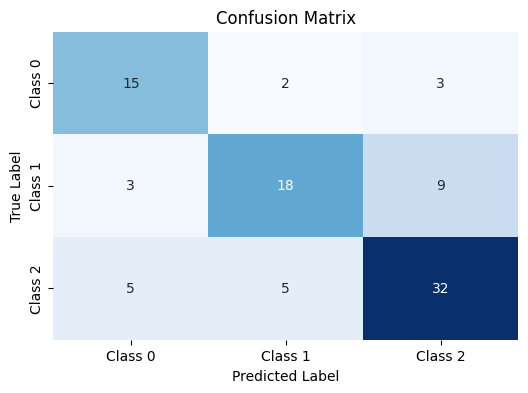

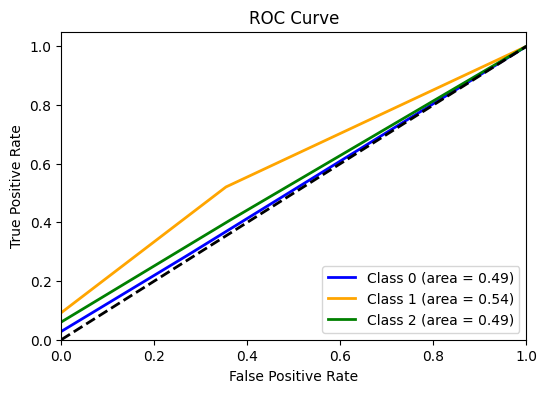

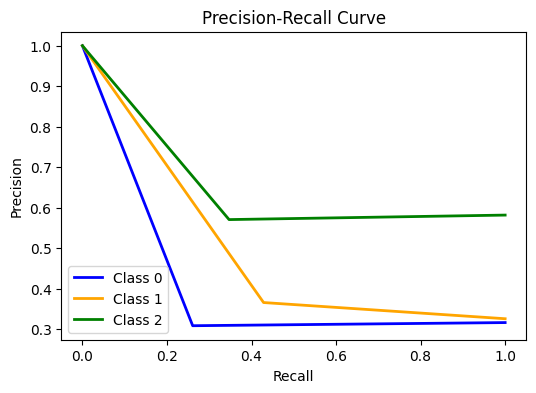

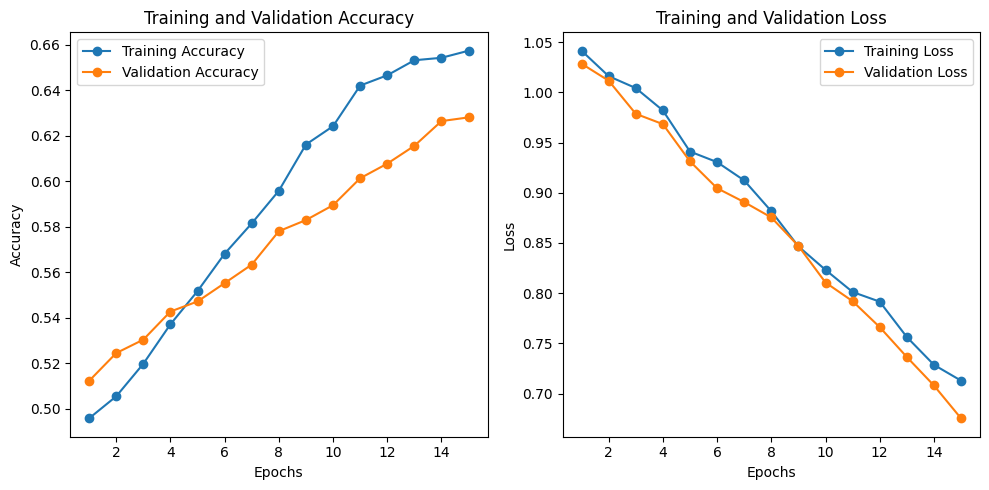


Test accuracy: 0.7412
Validation accuracy: 0.7701
Cohen's Kappa: 0.63
Log Loss: 0.7557


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess PNG images along with their labels
def load_and_preprocess_png_data(directory, label_map):
    images = []
    labels = []
    for label_name, label_value in label_map.items():
        label_dir = os.path.join(directory, label_name)
        if not os.path.exists(label_dir):
            continue

        png_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png')]
        for f in png_files:
            try:
                img = load_img(f, color_mode='grayscale', target_size=(224, 224))  # Load and resize the image
                img_array = img_to_array(img)
                img_array = img_array / 255.0  # Normalize pixel values
                images.append(img_array)
                labels.append(label_value)
            except Exception as e:
                print(f"Error loading file {f}: {e}")

    if len(images) == 0:
        print("No valid images found!")
        return None, None  # Return None if no valid images

    return np.array(images), np.array(labels)  # Return images and labels

# Data augmentation (returns both augmented images and labels)
def augment_data(images, labels):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        img = np.expand_dims(img, axis=0)
        count = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            augmented_labels.append(label)  # Duplicate the label for each augmented image
            count += 1
            if count >= 2:  # Augment each image twice (you can change this number)
                break

    return np.array(augmented_images), np.array(augmented_labels)

# Building a simplified Swin Transformer-like model for 3-class classification
def build_swin_transformer_classifier(image_size):
    inputs = layers.Input(shape=(image_size, image_size, 1))

    # Initial Convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Transformer-like Block
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Output layer for 3 classes (AD, CN, MCI)
    outputs = layers.Dense(3, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Training the model
def train_model(images, labels, image_size, epochs=10):
    model = build_swin_transformer_classifier(image_size)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Train the model and capture the training history
    history = model.fit(np.array(X_train), np.array(y_train), epochs=epochs, validation_data=(np.array(X_test), np.array(y_test)))

    return model, history, X_train, y_train, X_test, y_test

# Evaluating the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(np.array(X_test))
    y_pred_classes = np.argmax(y_pred, axis=1)

    print("Classification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=["AD", "CN", "MCI"]))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["AD", "CN", "MCI"], yticklabels=["AD", "CN", "MCI"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Main execution
directory = '/content/drive/MyDrive/project phase1/adni_classified2'  # Directory where your PNG images are stored
label_map = {'AD': 0, 'CN': 1, 'MCI': 2}  # Mapping of class names to numerical labels
images, labels = load_and_preprocess_png_data(directory, label_map)

if images is None:
    print("No images to process. Exiting...")
else:
    augmented_images, augmented_labels = augment_data(images, labels)  # Augment images and labels

    # Training the model
    image_size = 224
    model, history, X_train, y_train, X_test, y_test = train_model(augmented_images, augmented_labels, image_size, epochs=10)

    # Evaluate the model
    evaluate_model(model, X_test, y_test)


In [1]:
from sklearn.metrics import (
    classification_report, confusion_matrix, cohen_kappa_score, log_loss,
    precision_recall_fscore_support, accuracy_score
)
import pandas as pd

# Function to calculate and print detailed metrics in a table format
def print_detailed_metrics(model, X_test, y_test, class_names=["AD", "CN", "MCI"]):
    # Predict the test set
    y_pred = model.predict(np.array(X_test))
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    # Accuracy Scores
    test_accuracy = accuracy_score(y_test, y_pred_classes)
    validation_accuracy = model.history.history['val_accuracy'][-1]  # Last validation accuracy from training
    train_accuracy = model.history.history['accuracy'][-1]  # Last train accuracy from training

    # Precision, Recall, F1-Score, and Support
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred_classes, average=None)

    # Macro, Micro, and Weighted Averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='macro')
    micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='micro')
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')

    # Specificity, Sensitivity, False Positive Rate, False Negative Rate
    TPR = TP / (TP + FN)  # Sensitivity or Recall
    TNR = TN / (TN + FP)  # Specificity
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    # Cohen’s Kappa and Log Loss
    cohen_kappa = cohen_kappa_score(y_test, y_pred_classes)
    log_loss_value = log_loss(y_test, y_pred)

    # Compile metrics into a dictionary
    metrics = {
        "Class": class_names,
        "Support": support,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN,
        "TPR (Sensitivity/Recall)": TPR,
        "TNR (Specificity)": TNR,
        "FPR": FPR,
        "FNR": FNR,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "Validation Accuracy": [validation_accuracy] * len(class_names),
        "Test Accuracy": [test_accuracy] * len(class_names),
        "Train Accuracy": [train_accuracy] * len(class_names),
    }

    # Averages and additional metrics
    avg_metrics = {
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1-Score": macro_f1,
        "Micro Precision": micro_precision,
        "Micro Recall": micro_recall,
        "Micro F1-Score": micro_f1,
        "Weighted Precision": weighted_precision,
        "Weighted Recall": weighted_recall,
        "Weighted F1-Score": weighted_f1,
        "Cohen's Kappa": cohen_kappa,
        "Log Loss": log_loss_value
    }

    # Convert metrics dictionary to DataFrame for easy visualization
    metrics_df = pd.DataFrame(metrics)
    avg_metrics_df = pd.DataFrame(avg_metrics, index=[0])

    # Print detailed metrics table
    print("Class-specific Metrics:")
    display(metrics_df)
    print("\nAverage Metrics:")
    display(avg_metrics_df)

# Run the metrics function in a separate cell after training and evaluation
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
model = train_model(images, labels, image_size=224, epochs=10)  # Re-train the model if not already trained
print_detailed_metrics(model, X_test, y_test)


Evaluation Metrics
             Metric       AD       CN     MCI
                 TP  21.0000  39.0000 90.0000
                 FP  39.0000  12.0000 48.0000
                 FN  10.0000  11.0000  5.0000
                 TN 130.0000 138.0000 57.0000
                TPR   0.6770   0.7800  0.9470
                TNR   0.7690   0.9200  0.5430
                FPR   0.2310   0.0800  0.4570
                FNR   0.3230   0.2200  0.0530
             Recall   0.6770   0.7800  0.9470
        Specificity   0.7690   0.9200  0.5430
          Precision   0.3500   0.7650  0.6520
Validation Accuracy   0.7700   0.7700  0.7700
      Test Accuracy   0.8012   0.8012  0.8012
           F1-Score   0.4630   0.7720  0.7730
    Macro Precision   0.5890   0.5890  0.5890
       Macro Recall   0.8010   0.8010  0.8010
     Macro F1-Score   0.6690   0.6690  0.6690
 Weighted Precision   0.6650   0.6650  0.6650
    Weighted Recall   0.8010   0.8010  0.8010
  Weighted F1-Score   0.7070   0.7070  0.7070
      Cohen's K